This notebook uses XGBoost and a Neural Net to classify Good and Bad wines. The performance of both models is analyzed.

In [2]:
# This notebook does classification of the wines between good and bad.

# Following this, then in the p3workshop running pip install let me install the modules
#http://echrislynch.com/2019/02/01/adding-an-environment-to-jupyter-notebooks/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from IPython import display
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from xgboost import XGBRegressor
from xgboost import XGBClassifier

from tensorflow import keras
from tensorflow.keras import layers, callbacks


sns.set_palette("bright")

# Import the wine data set
data = pd.read_csv('wineQualityReds.csv', usecols=(np.arange(12)+1))

# Fix outliers in chlorides and residual sugar for better visualization
data["chlorides"] = pd.Series([min(x, 0.14) for x in data["chlorides"]])
data["residual.sugar"] = pd.Series([min(x, 4.) for x in data["residual.sugar"]])
data["total.sulfur.dioxide"] = pd.Series([min(x, 170.) for x in data["total.sulfur.dioxide"]])
data["sulphates"] = pd.Series([min(x, 1.4) for x in data["sulphates"]])

data["GoodBad"] = (np.sign(data["quality"]-6.5)+1.)/2.

In [3]:
# Define a function for preping data for the classification algorithm.
#print(data.columns)
def prep_for_classifier(data, rs):

    data_prep = data.copy(deep=True)
    y = data_prep.pop("GoodBad")
    data_prep = data_prep.drop("quality", axis=1)
    #print(data_prep.head())
    X_train, X_test, y_train, y_test = train_test_split(data_prep, y, test_size=0.3, random_state=rs)
    # random_state was 11121
    std_scaler = StandardScaler()
    X_cols = data_prep.columns
    X_train = std_scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, columns=X_cols)
    X_test = std_scaler.transform(X_test)
    X_test = pd.DataFrame(X_test, columns=X_cols)
    
    return [X_train, X_test, y_train, y_test]
    

In [27]:
# Fit the XGB Classifier to the original data set.
data_og = data.copy(deep=True)
Xog_train, Xog_test, yog_train, yog_test = prep_for_classifier(data, rs=1119)
#print(X_train.head())
xgbmodelog = XGBClassifier(n_estimators = 500, learning_rate=0.02, eval_metric="auc", n_jobs=4)
xgbmodelog.fit(Xog_train, yog_train, eval_set=[(Xog_test, yog_test)])

[0]	validation_0-auc:0.85879
[1]	validation_0-auc:0.85749
[2]	validation_0-auc:0.85723
[3]	validation_0-auc:0.86507
[4]	validation_0-auc:0.86442
[5]	validation_0-auc:0.86260
[6]	validation_0-auc:0.86367
[7]	validation_0-auc:0.86228
[8]	validation_0-auc:0.86842
[9]	validation_0-auc:0.86819
[10]	validation_0-auc:0.86772
[11]	validation_0-auc:0.86830
[12]	validation_0-auc:0.86974
[13]	validation_0-auc:0.87026
[14]	validation_0-auc:0.87109
[15]	validation_0-auc:0.87081
[16]	validation_0-auc:0.87153
[17]	validation_0-auc:0.87170
[18]	validation_0-auc:0.87172
[19]	validation_0-auc:0.87181
[20]	validation_0-auc:0.87265
[21]	validation_0-auc:0.87330
[22]	validation_0-auc:0.87242
[23]	validation_0-auc:0.87326
[24]	validation_0-auc:0.87309
[25]	validation_0-auc:0.87179
[26]	validation_0-auc:0.87037
[27]	validation_0-auc:0.87042
[28]	validation_0-auc:0.87000
[29]	validation_0-auc:0.86944
[30]	validation_0-auc:0.87042
[31]	validation_0-auc:0.87433
[32]	validation_0-auc:0.87535
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=4, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [28]:
xgb_results = xgbmodelog.predict(Xog_test)

One way to visualize the performance of the model is to plot the predicted values and actual values. Below, orange is the actual wine classification {1: Good, 0: Bad}, and blue is what the model predicted. Blue has been shifted vertically so correct predictions are visible.

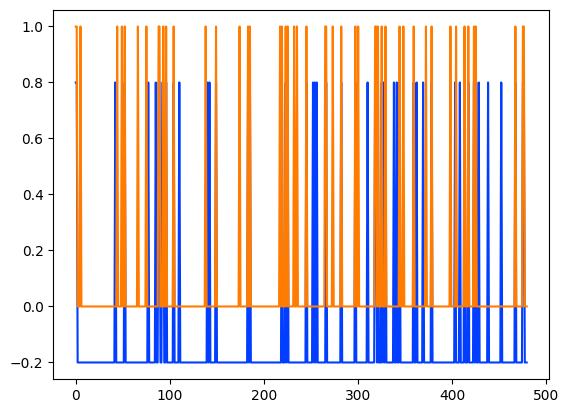

In [29]:
plt.plot(list(xgb_results-0.2))
plt.plot(list(yog_test))

We now look at some matrix and scalar ways to quantify the performance of our binary classification. 

In [30]:
# Rows are actual IDs {0: "Bad", 1: "Good"} and columns are predictions
print(confusion_matrix(yog_test, xgb_results))
# Precision is proportion of times a predicted 1 corresponds to a Good wine
print(precision_score(yog_test, xgb_results))
# Recall is the proportion of the total Good wines that the model IDs as Good.
print(recall_score(yog_test, xgb_results))
# F1 score is the harmonic mean of precision and recall
print(f1_score(yog_test, xgb_results))

[[409  21]
 [ 17  33]]
0.6111111111111112
0.66
0.6346153846153846


Now let's write some functions to make characterizing and training different models quick and easy!

In [31]:
def make_pr_plot(model, X_test, y_test):
    # Take in a model and test data and produce a confusion matrix and PR plot
    y_scores = model.predict_proba(X_test)
    mdl_thres = 1*(y_scores[:,1]> 0.5)
    print(confusion_matrix(y_test, mdl_thres))
    
    precs, recls, thrshs = precision_recall_curve(y_test, y_scores[:,1])
    
    plt.plot(precs, recls)
    plt.xlabel("Precision")
    plt.ylabel("Recall")

In [32]:
def make_pr_plot_cv(data, n_est=600, lr=0.02, eval_metric="auc", nn=False):
    
    """This function trains either an XGBoost classifier, or a dense Neural Network to identify good and bad wines.
    The input to the function is the data set, with the target column, n_est is the number of estimators in XGBoost
    or the number or training epochs for the neural network. lr and eval_metric are only for XGBoost. The function returns
    the precision and recall rates along with the corresponding selection thresholds for easy plotting of the PR curve."""
    
    data_prep = data.copy(deep=True)
    y = data_prep.pop("GoodBad")
    data_prep = data_prep.drop("quality", axis=1)
    #print(data_prep.head())
    #X_train, X_test, y_train, y_test = train_test_split(data_prep, y, test_size=0.3, random_state=rs)

    sKFold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1121)
    print("created skfold")
    print(sKFold.split(data_prep, y))
    print("above are the splits")
    i = 0
    ps_list = []
    rs_list = []
    for idx_train, idx_test in sKFold.split(data_prep, y):
    
        #print(idx_train)
        std_scaler = StandardScaler()
        X_cols = data_prep.columns
        X_train = std_scaler.fit_transform(data_prep.loc[idx_train])
        X_train = pd.DataFrame(X_train, columns=X_cols)
        y_train = y.loc[idx_train]
        X_test = std_scaler.transform(data_prep.loc[idx_test])
        X_test = pd.DataFrame(X_test, columns=X_cols)
        y_test = y.loc[idx_test]
    
        #X_train, X_test, y_trian, y_test = prep_for_classifier(data.loc[idx_train], rs)
        #print(X_train)
        #print(y_train)
        if nn == True:
            # Add the best NN model so far.
            early_stopping = callbacks.EarlyStopping(
                                    min_delta=0.0005, patience=30, restore_best_weights=True
                                    )

            model = keras.Sequential([
                layers.Dense(units=128, activation='relu', input_shape=[X_train.shape[1]]),
                layers.Dropout(0.2),
                layers.Dense(units=128, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(units=256, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(units=512, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(units=256, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(units=128, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(units=1, activation='sigmoid')
                ])

            model.compile(
                        optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=["binary_accuracy"]
                        )

            history = model.fit(
                            X_train, y_train,
                            validation_data=(X_test, y_test),
                            batch_size=256,
                            epochs=n_est,
                            callbacks=[early_stopping]
                            )

            y_scores = model.predict(X_test)
            
        else:
            xgbmodeltemp = XGBClassifier(n_estimators = n_est, learning_rate=lr, grow_policy="lossguide",
                                         eval_metric=eval_metric, n_jobs=4)
            xgbmodeltemp.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

            y_scores = xgbmodeltemp.predict_proba(X_test)[:,1]

        if i == 0:
            print("in i==0")
            precs, recls, thrshs = precision_recall_curve(y_test, y_scores)
            ps_list.append(precs)
            rs_list.append(recls)
            print(len(ps_list))
        else:
            print('i is ', i)
            
            ps_list.append([])
            rs_list.append([])
            
            for thr in thrshs:
                y_preds = 1.*(y_scores> thr)
                ps_list[i].append(precision_score(y_test, y_preds, zero_division=0))
                rs_list[i].append(recall_score(y_test, y_preds))
            
        
        i += 1
    
    prec_df = pd.DataFrame(ps_list).transpose()
    prec_df.columns = ["S1", "S2", "S3"]
    #print(prec_df.head())
    precs = prec_df.mean(axis=1)
    
    recl_df = pd.DataFrame(rs_list).transpose()
    recl_df.columns = ["S1", "S2", "S3"]
    recls = recl_df.mean(axis=1)
    
    return thrshs, precs, recls

created skfold
<generator object _BaseKFold.split at 0x000002B1149E0BC8>
above are the splits
in i==0
1
i is  1
i is  2


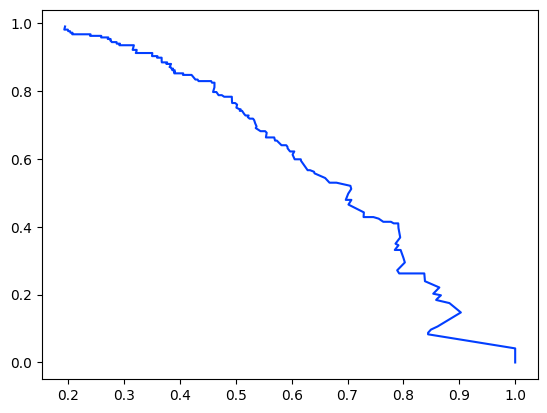

In [33]:
ths, psog, rsog = make_pr_plot_cv(data)
#print(ps)
#print(rs)
plt.plot(psog, rsog)

In [34]:
# See how the confusion matrix changes with a different threshold.
y_scores = xgbmodelog.predict_proba(Xog_test)
#print(y_scores[:,1])
gbthrsh = 0.6
xgb_thres = 1*(y_scores[:,1] > gbthrsh)
#print(xgb_thres)
print(confusion_matrix(yog_test, xgb_thres))

[[413  17]
 [ 18  32]]


The PR plot is a parametric plot with parametric parameter threshold, so let's look at precision and recall both a functions of threshold.

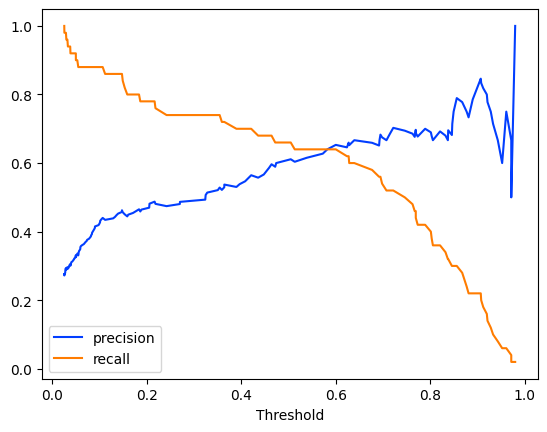

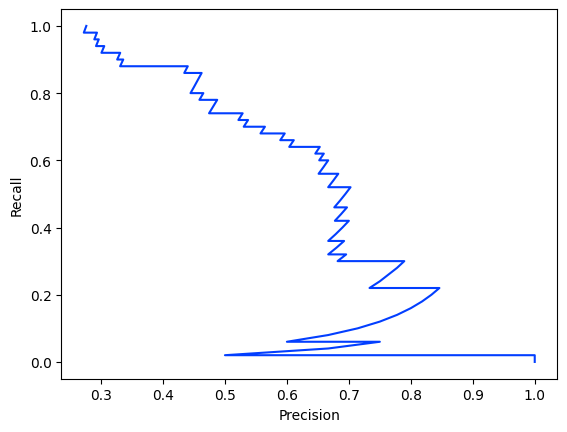

In [35]:
precs, recls, thrshs = precision_recall_curve(yog_test, y_scores[:,1])
#print(thrshs)
plt.plot(thrshs, precs[:-1], label="precision")
plt.plot(thrshs, recls[:-1], label="recall")
plt.xlabel("Threshold")
plt.legend()
plt.show()

# Plot Recall-Precision plot
plt.plot(precs, recls)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show()

AUC  0.9373488372093023


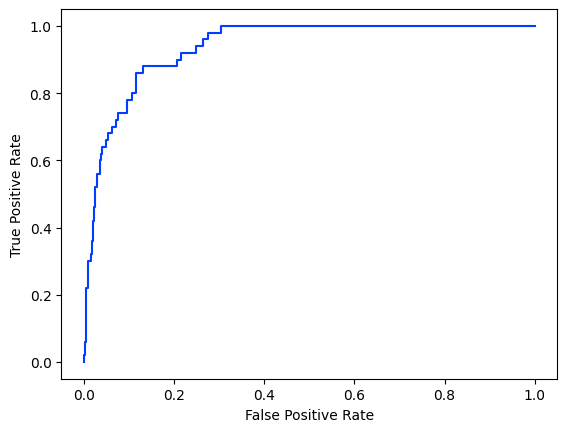

In [36]:
# Make and plot the ROC curve
fpr, tpr, thrshs = roc_curve(yog_test, y_scores[:,1])

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
print("AUC ", roc_auc_score(yog_test, y_scores[:,1]))

The AUC (area under curve) metric looks pretty good, but the precision-recall curve almost looks like a straight line. This is because the "Good" wines are a much smaller fraction of our dataset than the "Bad" wines. Thus, we will continue judging our models by the PR curve, not ROC. It also seems our classification model might have room for improvement. Let's first start by training only in the high-quality sub-volume, uncovered in the 'presentation' notebook, and see if that can help the classifier.

In [37]:
idx_vol = data.loc[(data["alcohol"] > 11.) & (data["volatile.acidity"] < 0.5) & (data["sulphates"] > 0.65)].index
print(idx_vol)

Int64Index([ 142,  144,  267,  278,  327,  330,  331,  336,  338,  341,
            ...
            1477, 1509, 1530, 1544, 1549, 1566, 1570, 1584, 1585, 1586],
           dtype='int64', length=149)


In [38]:
# Fit the XGB Classifier to the selected data only.
Xv_train, Xv_test, yv_train, yv_test = prep_for_classifier(data.loc[idx_vol], rs=1112)
#print(X_train.head())
xgbmodelv = XGBClassifier(n_estimators = 200, learning_rate=0.07, eval_metric="auc", n_jobs=4)
xgbmodelv.fit(Xv_train, yv_train, eval_set=[(Xv_test, yv_test)], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.07, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=4, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

[[10 13]
 [ 6 16]]


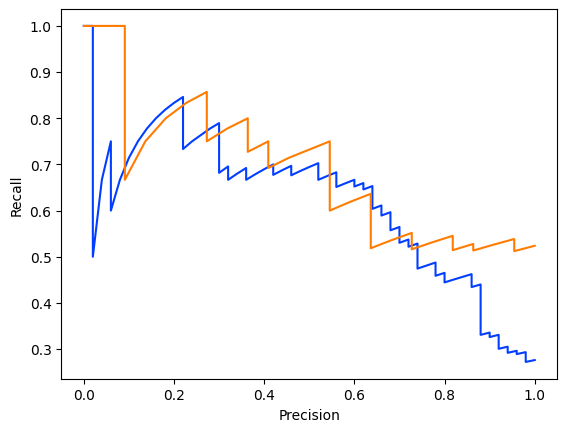

In [39]:
y_scores = xgbmodelog.predict_proba(Xog_test)
yv_scores = xgbmodelv.predict_proba(Xv_test)

gbthrsh = 0.5
xgb_thres = 1*(y_scores[:,1] > gbthrsh)
xgb_thresv = 1*(yv_scores[:,1] > gbthrsh)
#print(xgb_thres)
print(confusion_matrix(yv_test, xgb_thresv))
      
# Plot Recall-Precision plot
precs, recls, thrshs = precision_recall_curve(yog_test, y_scores[:,1])
precsv, reclsv, thrshsv = precision_recall_curve(yv_test, yv_scores[:,1])
plt.plot(recls, precs)
plt.plot(reclsv, precsv)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show()

In [46]:
data["in.volume"] = 1.*np.where((data["alcohol"] > 11.) & (data["volatile.acidity"] < 0.5) & (data["sulphates"] > 0.65), True, False)
#print(data.loc[140:145])

# Fit the XGB Classifier to the original data set.
X_train, X_test, y_train, y_test = prep_for_classifier(data, rs=1114)
#print(X_train.head())
xgbmodel = XGBClassifier(n_estimators = 200, learning_rate=0.07, eval_metric="auc", n_jobs=4)
xgbmodel.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-auc:0.83765
[1]	validation_0-auc:0.83785
[2]	validation_0-auc:0.84149
[3]	validation_0-auc:0.84071
[4]	validation_0-auc:0.85225
[5]	validation_0-auc:0.85919
[6]	validation_0-auc:0.85681
[7]	validation_0-auc:0.86354
[8]	validation_0-auc:0.86611
[9]	validation_0-auc:0.86655
[10]	validation_0-auc:0.86697
[11]	validation_0-auc:0.86755
[12]	validation_0-auc:0.86576
[13]	validation_0-auc:0.86775
[14]	validation_0-auc:0.86940
[15]	validation_0-auc:0.86874
[16]	validation_0-auc:0.86801
[17]	validation_0-auc:0.87134
[18]	validation_0-auc:0.87105
[19]	validation_0-auc:0.87240
[20]	validation_0-auc:0.87332
[21]	validation_0-auc:0.87156
[22]	validation_0-auc:0.87312
[23]	validation_0-auc:0.87374
[24]	validation_0-auc:0.87560
[25]	validation_0-auc:0.87692
[26]	validation_0-auc:0.87736
[27]	validation_0-auc:0.87813
[28]	validation_0-auc:0.88117
[29]	validation_0-auc:0.88029
[30]	validation_0-auc:0.88347
[31]	validation_0-auc:0.88384
[32]	validation_0-auc:0.88523
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.07, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=4, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

[[404  10]
 [ 33  33]]


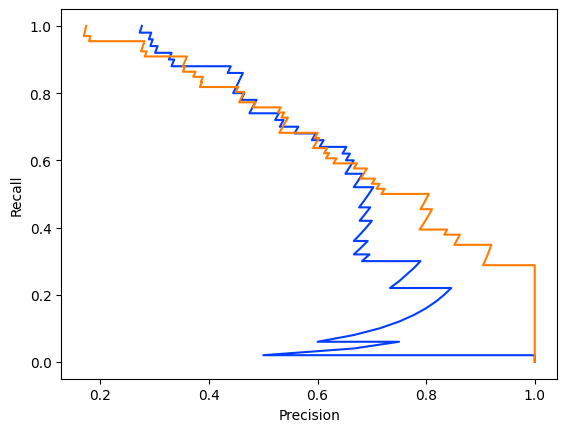

In [47]:
yv_scores = xgbmodel.predict_proba(X_test)

gbthrsh = 0.5
#xgb_thres = 1*(y_scores[:,1] > gbthrsh)
xgb_thresv = 1*(yv_scores[:,1] > gbthrsh)
#print(xgb_thres)
print(confusion_matrix(y_test, xgb_thresv))

precs, recls, thrshs = precision_recall_curve(yog_test, y_scores[:,1])
precsv, reclsv, thrshsv = precision_recall_curve(y_test, yv_scores[:,1])
plt.plot(precs, recls)
plt.plot(precsv, reclsv)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show()

The performance is the high-quality volume is not better than throwing darts, so let's drop this and return to the full data set. Adding in a binary feature for whether the wine was in our high-quality volume did not improve the classification model. This makes sense, as the xg-Boost classifier is made of underlying trees that should be partitioning the data by value anyway.

Now let's look for new features that can enhance model predictiveness.

In [48]:
data = data.drop("in.volume", axis=1)
print("Dropped in.volume column")

Dropped in.volume column


In [50]:
# Try ratios containing 'alcohol' property.

data = data_og.copy(deep=True)
#print(data.head())
#print(data_og.head())
data["ratio"] = data["alcohol"]/(data["citric.acid"]+0.3)
data["ratio1"] = data["alcohol"]/(data["fixed.acidity"]+0.0)
data["ratio2"] = data["alcohol"]/(data["free.sulfur.dioxide"]+0)
#print(data_og.head())
#data = data.drop("ratio", axis=1)
# Fit the XGB Classifier to the original data set.
X_train, X_test, y_train, y_test = prep_for_classifier(data, rs=1115)
#print(X_train.head())
xgbmodel = XGBClassifier(n_estimators = 200, learning_rate=0.07, eval_metric="auc", n_jobs=4)
xgbmodel.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.07, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=4, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

[[409  21]
 [ 17  33]]
[[404  18]
 [ 28  30]]


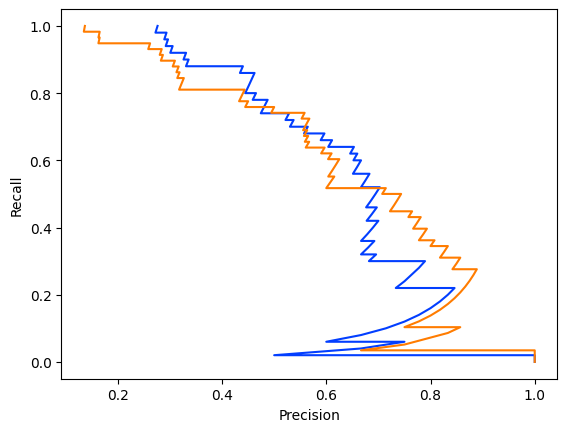

In [51]:
make_pr_plot(xgbmodelog, Xog_test, yog_test)
make_pr_plot(xgbmodel, X_test, y_test)

This improvement by adding the alcohol ratio features proved to be a double-edged sword. It increased aread under the curve, but actually made the model performance worse at our optimal precision of around 65%. This is apparent in the confusion matrix, which shows that our new model correctly found one more bad wine, but to do so, it incorrectly classified 3 good wines as bad. So let's now search for features that improve recall at higher precisions.

In [53]:
data = data_og.copy(deep=True)
#data["ratio"] = data["alcohol"]/(data["citric.acid"]+0.3)
#data["ratio1"] = data["alcohol"]/(data["fixed.acidity"]+0.0)
#data["ratio2"] = data["alcohol"]/(data["free.sulfur.dioxide"]+0)
#data["ratio3"] = data["volatile.acidity"]/(data["density"])
#data["ratio4"] = data["volatile.acidity"]/(data["citric.acid"]+0.1)
#data["ratio5"] = data["volatile.acidity"]/(data["total.sulfur.dioxide"]+20)
#data["ratio6"] = data["volatile.acidity"]/(data["residual.sugar"]+0.)
data["ratio6"] = data["chlorides"]/(data["residual.sugar"]+0.)
#print(data.head())
#print(data_og.head())
#data = data.drop("ratio", axis=1)
# Fit the XGB Classifier to the original data set.
X_train, X_test, y_train, y_test = prep_for_classifier(data, 111)
#print(X_train.head())
xgbmodel = XGBClassifier(n_estimators = 400, max_depth=6, learning_rate=0.025, early_stopping=5,
                         grow_policy="lossguide", eval_metric="auc", n_jobs=4)
xgbmodel.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[12:06:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stopping" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.87923
[1]	validation_0-auc:0.87927
[2]	validation_0-auc:0.87866
[3]	validation_0-auc:0.87796
[4]	validation_0-auc:0.87873
[5]	validation_0-auc:0.87824
[6]	validation_0-auc:0.87922
[7]	validation_0-auc:0.87828
[8]	validation_0-auc:0.87857
[9]	validation_0-auc:0.87915
[10]	validation_0-auc:0.87965
[11]	validation_0-auc:0.87986
[12]	validation_0-auc:0.87974
[13]	validation_0-auc:0.88082
[14]	validation_0-auc:0.88052
[15]	validation_0-auc:0.88885
[16]	validation_0-auc:0.89091
[17]	validation_0-auc:0.89059
[18]	validation_0-auc:0.89488
[19]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping=5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints='', learning_rate=0.025, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

[[409  21]
 [ 17  33]]
[[398  12]
 [ 29  41]]


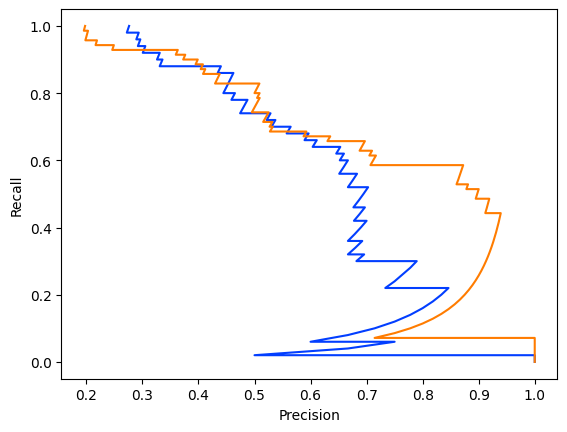

In [54]:
make_pr_plot(xgbmodelog, Xog_test, yog_test)
make_pr_plot(xgbmodel, X_test, y_test)

created skfold
<generator object _BaseKFold.split at 0x000002B11760D9C8>
above are the splits
in i==0
1
i is  1
i is  2


Text(0, 0.5, 'Recall')

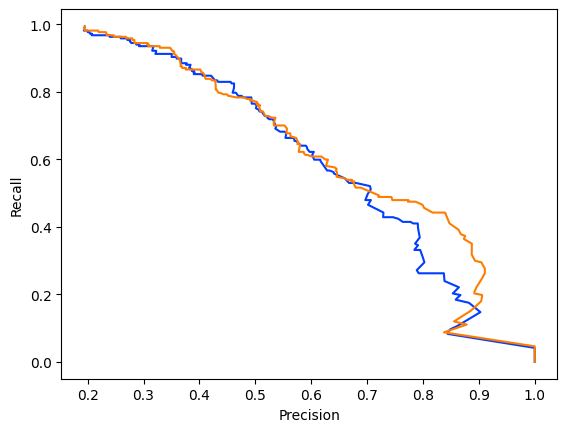

In [55]:
data = data_og.copy(deep=True)
#data["ratio"] = data["alcohol"]/(data["citric.acid"]+0.3)
#data["ratio1"] = data["alcohol"]/(data["fixed.acidity"]+0.0) # worse performance alone
#data["ratio2"] = data["alcohol"]/(data["free.sulfur.dioxide"]+0)
#data["ratio3"] = data["volatile.acidity"]/(data["density"]) # worse performance alone
data["ratio4"] = data["volatile.acidity"]/(data["citric.acid"]+0.1) # improves when add with below too
data["ratio5"] = data["volatile.acidity"]/(data["total.sulfur.dioxide"]+20) # improves when added alone
data["ratio6"] = data["volatile.acidity"]/(data["residual.sugar"]+0.) # improves with one above too
#data["ratio7"] = data["citric.acid"]/(data["residual.sugar"]+0.) # alone and with 3 above doesn't really change model
ths, ps, rs = make_pr_plot_cv(data, 900, 0.02, eval_metric="aucpr")

plt.plot(psog, rsog)
plt.plot(ps, rs)
plt.xlabel("Precision")
plt.ylabel("Recall")

created skfold
<generator object _BaseKFold.split at 0x000002B114CBB948>
above are the splits
Epoch 1/300
5/5 [==============================] - 2s 81ms/step - loss: 0.5402 - binary_accuracy: 0.7833 - val_loss: 0.3824 - val_binary_accuracy: 0.8649
Epoch 2/300
5/5 [==============================] - 0s 25ms/step - loss: 0.4352 - binary_accuracy: 0.8640 - val_loss: 0.3463 - val_binary_accuracy: 0.8649
Epoch 3/300
5/5 [==============================] - 0s 23ms/step - loss: 0.3696 - binary_accuracy: 0.8640 - val_loss: 0.3706 - val_binary_accuracy: 0.8649
Epoch 4/300
5/5 [==============================] - 0s 25ms/step - loss: 0.3383 - binary_accuracy: 0.8640 - val_loss: 0.2895 - val_binary_accuracy: 0.8649
Epoch 5/300
5/5 [==============================] - 0s 25ms/step - loss: 0.3298 - binary_accuracy: 0.8640 - val_loss: 0.2818 - val_binary_accuracy: 0.8649
Epoch 6/300
5/5 [==============================] - 0s 24ms/step - loss: 0.2945 - binary_accuracy: 0.8640 - val_loss: 0.2959 - val_binary

Text(0, 0.5, 'Recall')

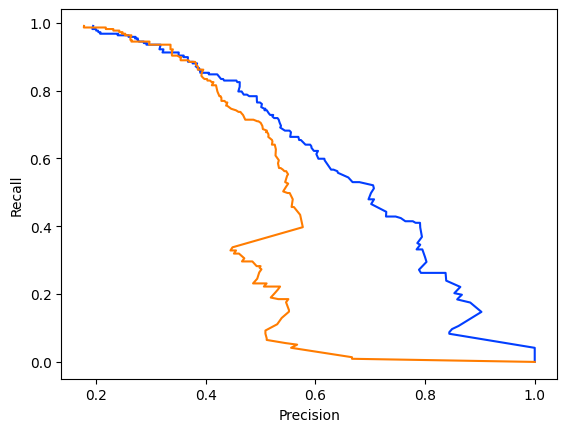

In [56]:
data = data_og.copy(deep=True)

data["ratio4"] = data["volatile.acidity"]/(data["citric.acid"]+0.1) # improves when add with below too
data["ratio5"] = data["volatile.acidity"]/(data["total.sulfur.dioxide"]+20) # improves when added alone
data["ratio6"] = data["volatile.acidity"]/(data["residual.sugar"]+0.) # improves with one above too

ths, ps, rs = make_pr_plot_cv(data, n_est=300, nn=True)
plt.plot(psog, rsog)
plt.plot(ps, rs)
plt.xlabel("Precision")
plt.ylabel("Recall")

Text(0, 0.5, 'Recall')

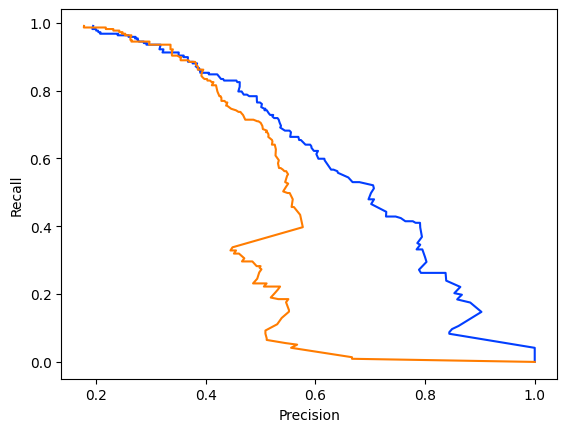

In [57]:
plt.plot(psog, rsog)
plt.plot(ps, rs)
plt.xlabel("Precision")
plt.ylabel("Recall")

Decent model:
                model = keras.Sequential([
                layers.Dense(units=256, activation='relu', input_shape=[X_train.shape[1]]),
                layers.Dropout(0.2),
                layers.Dense(units=512, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(units=1024, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(units=512, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(units=128, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(units=1, activation='sigmoid')
                ])
                
                
This model worked well too:
            model = keras.Sequential([
                layers.Dense(units=256, activation='relu', input_shape=[X_train.shape[1]]),
                layers.Dropout(0.2),
                layers.Dense(units=256, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(units=256, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(units=256, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(units=256, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(units=256, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(units=1, activation='sigmoid')
                ])
                
                
Another good model

Above we have documented a couple models that gave promising results, but ultimately, a neural network did not do a better job classifying good and wines than XGBoost did.